<a href="https://colab.research.google.com/github/LionelSh/Jedha-SpamDetector-B4/blob/main/Spam_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stages of work

Stages of work
1. EDA
2. Preprocessing
3. Model
4. Graphs
5. Saving models


# Imports

In [ ]:
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns




# EDA

In [ ]:
file_name = 'spam.csv'
df = pd.read_csv(file_name, engine='python', encoding = "ISO-8859-1")


In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
print('exploring missing values:')
df.isna().sum()/df.shape[0]*100

exploring missing values:


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [ ]:
df.dtypes

v1            object
v2            object
Unnamed: 2    object
Unnamed: 3    object
Unnamed: 4    object
dtype: object

In [ ]:
df = df.loc[:,['v1','v2']]

In [ ]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.rename(columns = {'v1':'Category','v2':'sms_text'}, inplace=True)


In [ ]:
df.head()

,Category,sms_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

# Preprocessing

## Spacy

In [ ]:
import spacy

In [ ]:
#pip install tensorrt

In [ ]:
!python -m spacy download en_core_web_md -q

2023-07-12 21:29:01.678028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 35.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
import en_core_web_md
nlp = en_core_web_md.load()

In [ ]:
# Import Stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
# Remove all non alphanumeric characters except whitespaces
df["sms_clean"] = df["sms_text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# remove double spaces and spaces at the beginning and end of strings
df["sms_clean"] = df["sms_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove stop words and replace everyword with their lemma
df["sms_clean"] = df["sms_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [ ]:
df.head(10)

,Category,sms_text,sms_clean
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darle 3 week word d like fun tb ok...
6,ham,Even my brother is not like to speak with me. ...,brother like speak treat like aids patent
7,ham,As per your request 'Melle Melle (Oru Minnamin...,request melle melle oru minnaminunginte nurung...
8,spam,WINNER!! As a valued network customer you have...,winner value network customer select receivea ...
9,spam,Had your mobile 11 months or more? U R entitle...,mobile 11 month u r entitle update late colour...


We have used spacy despite the presence of too many unofficial English language, we'll try more than one option and investigate the results

In [ ]:
df['Label'] = df['Category'].apply(lambda x : 1 if x == 'spam' else 0)

In [ ]:
df.head()

,Category,sms_text,sms_clean,Label
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,0


## Tokenizing

a) First initialize a **tokenizer**

b) second fit it to the current vocabulary

c) finally, tokenize

After that we will implement **padding** to have a fixed length of input in order to transfer to **tensorflow**

### Tokenizer

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(df['sms_clean'])
df["sms_encoded"] = tokenizer.texts_to_sequences(df['sms_clean'])

In [ ]:
df.head()

,Category,sms_text,sms_clean,Label,sms_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0,"[1, 232, 447, 462, 941, 36, 53, 206, 942, 79, ..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0,"[10, 195, 463, 289, 2, 1]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1,"[12, 302, 4, 531, 659, 33, 1, 845, 423, 1, 1, ..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,0,"[2, 125, 149, 1, 2, 85]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,0,"[705, 23, 660, 130]"


make sure that there are no empty fields that may result if the text contained only stopping words.

In [ ]:
mask = df['sms_clean'].apply(lambda x: type(x)==str)
mask.value_counts()

True    5572
Name: sms_clean, dtype: int64

### Padding

In [ ]:
sms_padded = tf.keras.preprocessing.sequence.pad_sequences(df['sms_encoded'], padding="post")

In [ ]:
# hereby is the sms_padded, all the smss have the same length
# this is necessary inorder to transfer to tensors
sms_padded

array([[  1, 232, 447, ...,   0,   0,   0],
       [ 10, 195, 463, ...,   0,   0,   0],
       [ 12, 302,   4, ...,   0,   0,   0],
       ...,
       [  1, 936,   1, ...,   0,   0,   0],
       [113,   1,   1, ...,   0,   0,   0],
       [  1, 322,   0, ...,   0,   0,   0]], dtype=int32)

In [ ]:
print(f"the padded data shape is {sms_padded.shape}")

the padded data shape is (5572, 72)


In [ ]:
sms_padded[0]

array([  1, 232, 447, 462, 941,  36,  53, 206, 942,  79,   1, 943,   1,
        60,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Splitting

In [ ]:
# split the data into training and validation
xtrain, xval, ytrain, yval = train_test_split(sms_padded,df['Label'], test_size=0.2)

### transfer to tensorflow

In [ ]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

### Shuffle and Batch

In [ ]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [ ]:
for sms , label in train_batch.take(1):
  print(sms,label)

tf.Tensor(
[[262   0   0 ...   0   0   0]
 [  2 161   0 ...   0   0   0]
 [ 27 315  27 ...   0   0   0]
 ...
 [ 55 187   3 ...   0   0   0]
 [ 42 260   7 ...   0   0   0]
 [263 272   6 ...   0   0   0]], shape=(64, 72), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0], shape=(64,), dtype=int64)


In [ ]:
sms.shape[1]

72

# Model

## 1. Simple classification Model

In [ ]:
tokenizer.num_words

1000

In [ ]:
vocab_size = tokenizer.num_words
model_simple = tf.keras.Sequential([
                  # Word Embedding layer
                  # the input_dim = vocabulary_size = tokenizer number of words
                  # vocab_size + 1 is due zero padding
                  # the output_dim is the number of vectors we desire to express for each word
                  # what about the input sequence or shape? actually it is the number of words in
                  # the sentence each time which is the number of columns in the resulted

                  tf.keras.layers.Embedding(vocab_size+1, 8,input_length=sms.shape[1],name="embedding"),

                  # Gobal average pooling
                  # This is to normalize the data into one vector for the dense layer
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(128, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model_simple.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 8)             8008      
                                                                 
 global_average_pooling1d_7   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 128)               1152      
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9,289
Trainable params: 9,289
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer= tf.keras.optimizers.Adam()

model_simple.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model_simple.fit(
    train_batch,
    validation_data=val_batch,
    epochs=25,
    )

Epoch 1/25
70/70 [==============================] - 2s 5ms/step - loss: 0.5757 - accuracy: 0.8564 - val_loss: 0.4361 - val_accuracy: 0.8592
Epoch 2/25
70/70 [==============================] - 0s 3ms/step - loss: 0.3768 - accuracy: 0.8676 - val_loss: 0.3733 - val_accuracy: 0.8592
Epoch 3/25
70/70 [==============================] - 0s 3ms/step - loss: 0.3516 - accuracy: 0.8676 - val_loss: 0.3566 - val_accuracy: 0.8592
Epoch 4/25
70/70 [==============================] - 0s 3ms/step - loss: 0.3329 - accuracy: 0.8676 - val_loss: 0.3323 - val_accuracy: 0.8592
Epoch 5/25
70/70 [==============================] - 0s 3ms/step - loss: 0.3037 - accuracy: 0.8676 - val_loss: 0.2938 - val_accuracy: 0.8592
Epoch 6/25
70/70 [==============================] - 0s 3ms/step - loss: 0.2584 - accuracy: 0.8676 - val_loss: 0.2410 - val_accuracy: 0.8592
Epoch 7/25
70/70 [==============================] - 0s 3ms/step - loss: 0.2112 - accuracy: 0.8676 - val_loss: 0.2043 - val_accuracy: 0.8592
Epoch 8/25
70/70 [==

In [ ]:
type(history)

keras.callbacks.History

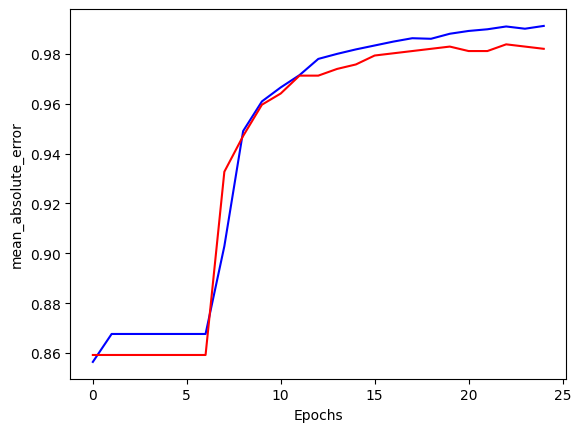

In [ ]:
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("mean_absolute_error")
plt.xlabel("Epochs")
plt.show()

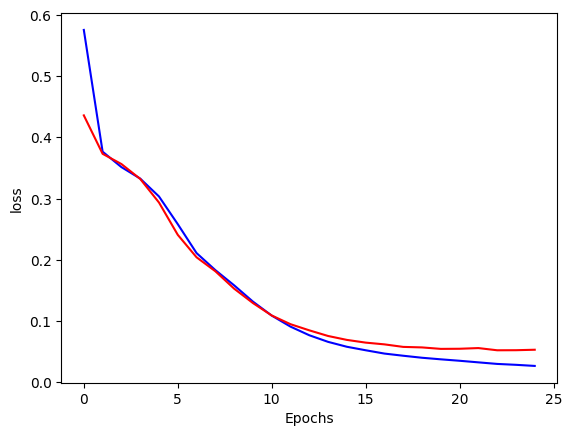

In [ ]:
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

## LSTM Model

In [ ]:
model_lstm = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_length=sms.shape[1],name="embedding"),
                  LSTM(units=64, return_sequences=True), # maintains the sequential nature
                  LSTM(units=32, return_sequences=False), # returns the last output
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  Dense(1, activation="sigmoid", name="last")
])

In [ ]:
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(),

              loss=tf.keras.losses.BinaryCrossentropy() ,
              metrics=['accuracy'])



In [ ]:
history_lstm = model_lstm.fit(train_batch,
              epochs=20,
              validation_data=val_batch)

Epoch 1/20
70/70 [==============================] - 14s 134ms/step - loss: 0.4215 - accuracy: 0.8676 - val_loss: 0.4064 - val_accuracy: 0.8592
Epoch 2/20
70/70 [==============================] - 7s 104ms/step - loss: 0.3926 - accuracy: 0.8676 - val_loss: 0.4064 - val_accuracy: 0.8592
Epoch 3/20
70/70 [==============================] - 8s 120ms/step - loss: 0.3916 - accuracy: 0.8676 - val_loss: 0.4070 - val_accuracy: 0.8592
Epoch 4/20
70/70 [==============================] - 8s 112ms/step - loss: 0.3920 - accuracy: 0.8676 - val_loss: 0.4078 - val_accuracy: 0.8592
Epoch 5/20
70/70 [==============================] - 8s 112ms/step - loss: 0.3913 - accuracy: 0.8676 - val_loss: 0.4067 - val_accuracy: 0.8592
Epoch 6/20
70/70 [==============================] - 8s 119ms/step - loss: 0.3911 - accuracy: 0.8676 - val_loss: 0.4064 - val_accuracy: 0.8592
Epoch 7/20
70/70 [==============================] - 8s 121ms/step - loss: 0.3914 - accuracy: 0.8676 - val_loss: 0.4092 - val_accuracy: 0.8592
Epoch

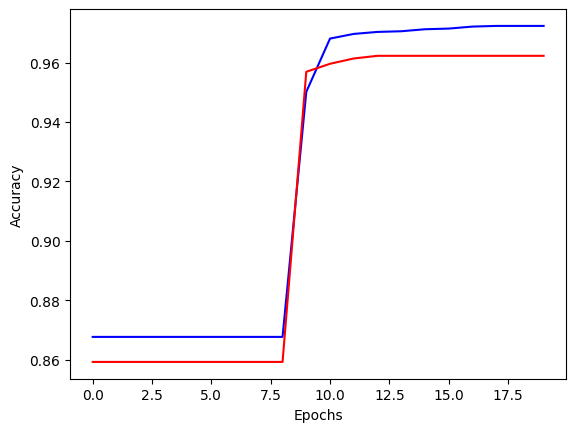

In [ ]:
plt.plot(history_lstm.history["accuracy"], color="b")
plt.plot(history_lstm.history["val_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

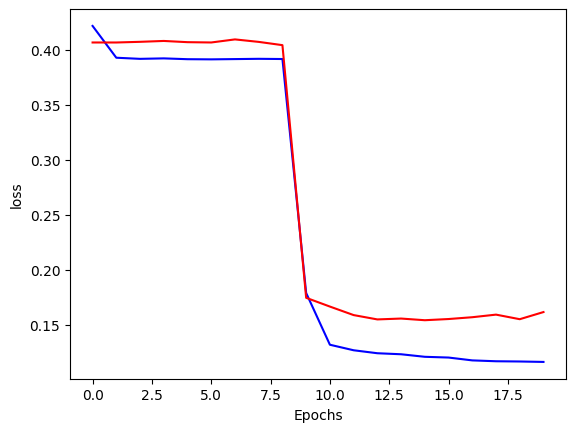

In [ ]:
plt.plot(history_lstm.history["loss"], color="b")
plt.plot(history_lstm.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

model = Sequential()
model_convadd(Embedding(max_words, 32, input_length=max_length))
model_convadd(Conv1D(32, 7, activation='relu'))
model_convadd(MaxPooling1D(5))
model_convadd(Conv1D(32, 7, activation='relu'))
model_convadd(GlobalMaxPooling1D())
model_convadd(Dense(1, activation='sigmoid'))
model_convcompile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_convsummary()

## A Model based on convelution  

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

model_conv = tf.keras.models.Sequential()
model_conv.add(Embedding(vocab_size, 64, input_length=sms.shape[1]))
model_conv.add(Conv1D(32, 7, activation='relu'))
model_conv.add(MaxPooling1D(5))
model_conv.add(Conv1D(32, 7, activation='relu'))
model_conv.add(GlobalMaxPooling1D())
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_conv.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 64)            64000     
                                                                 
 conv1d (Conv1D)             (None, 66, 32)            14368     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 32)             7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_86 (Dense)            (None, 1)               

In [ ]:
history_conv = model_conv.fit(train_batch,
              epochs=20,
              validation_data=val_batch)

Epoch 1/20
70/70 [==============================] - 3s 23ms/step - loss: 0.4025 - accuracy: 0.8640 - val_loss: 0.2895 - val_accuracy: 0.8565
Epoch 2/20
70/70 [==============================] - 1s 21ms/step - loss: 0.1641 - accuracy: 0.9390 - val_loss: 0.0897 - val_accuracy: 0.9749
Epoch 3/20
70/70 [==============================] - 1s 20ms/step - loss: 0.0620 - accuracy: 0.9823 - val_loss: 0.0582 - val_accuracy: 0.9830
Epoch 4/20
70/70 [==============================] - 2s 27ms/step - loss: 0.0375 - accuracy: 0.9872 - val_loss: 0.0538 - val_accuracy: 0.9839
Epoch 5/20
70/70 [==============================] - 2s 22ms/step - loss: 0.0245 - accuracy: 0.9919 - val_loss: 0.0514 - val_accuracy: 0.9857
Epoch 6/20
70/70 [==============================] - 1s 20ms/step - loss: 0.0172 - accuracy: 0.9960 - val_loss: 0.0521 - val_accuracy: 0.9839
Epoch 7/20
70/70 [==============================] - 2s 21ms/step - loss: 0.0126 - accuracy: 0.9969 - val_loss: 0.0536 - val_accuracy: 0.9857
Epoch 8/20
70

[]

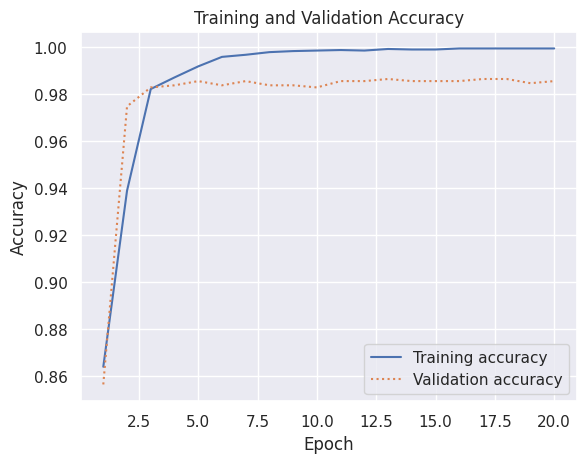

In [ ]:

%matplotlib inline
sns.set()

acc = history_conv.history['accuracy']
val = history_conv.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

# Model Tuning


In [ ]:
pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.2 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#bert-base-uncased smaller version of the base BERT model,
#trained on uncased (lowercased) English text
#has 12 Transformer layers, 12 attention heads, and 110 million parameters."

In [ ]:

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
input_ids = tokenizer(df['sms_clean'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='tf')
labels = df['Label'].values


In [ ]:


#train test split / in the context train Validation split

X_train, X_val, y_train, y_val = train_test_split(input_ids['input_ids'].numpy(), labels, random_state=42, test_size=0.2)
### input_ids python needs it in numpy
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08) #2e-5 is a convenitional rate


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')


In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [ ]:
model.fit(train_dataset.shuffle(1000).batch(16), epochs=2, batch_size=16, validation_data=validation_dataset.batch(16))


Epoch 1/2
279/279 [==============================] - 114s 220ms/step - loss: 0.1110 - accuracy: 0.9646 - val_loss: 0.0516 - val_accuracy: 0.9883
Epoch 2/2
279/279 [==============================] - 42s 151ms/step - loss: 0.0359 - accuracy: 0.9897 - val_loss: 0.0389 - val_accuracy: 0.9865


In [ ]:
model.evaluate(validation_dataset.batch(16))


70/70 [==============================] - 4s 54ms/step - loss: 0.0389 - accuracy: 0.9865


[0.03892456367611885, 0.9865471124649048]

In [ ]:
# Assuming model is your trained model and val_dataset is your validation data.
predictions = model.predict(validation_dataset.batch(16))

logits = predictions.logits

probabilities = tf.nn.softmax(logits, axis=-1)

predicted_labels = tf.argmax(probabilities, axis=-1)

predicted_labels = predicted_labels.numpy()

print(y_val.shape)
print(predicted_labels.shape)



cm = confusion_matrix(y_val, predicted_labels)
print("Confusion Matrix:")
print(cm)



70/70 [==============================] - 4s 52ms/step
(1115,)
(1115,)
Confusion Matrix:
[[953  12]
 [  3 147]]


In [ ]:
cr = classification_report(y_val, predicted_labels)
print("Classification Report:")
print(cr)




Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       965
           1       0.92      0.98      0.95       150

    accuracy                           0.99      1115
   macro avg       0.96      0.98      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [ ]:
# We can also print the classification report
print(classification_report(y_val, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       965
           1       0.92      0.98      0.95       150

    accuracy                           0.99      1115
   macro avg       0.96      0.98      0.97      1115
weighted avg       0.99      0.99      0.99      1115



Another parameters:

In [ ]:

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
input_ids = tokenizer(df['sms_clean'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='tf')
labels = df['Label'].values


In [ ]:


#train test split / in the context train Validation split

X_train, X_val, y_train, y_val = train_test_split(input_ids['input_ids'].numpy(), labels, random_state=42, test_size=0.2)
### input_ids python needs it in numpy
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08) #2e-5 is a convenitional rate


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metric = tf.keras.metrics.BinaryCrossentropy('accuracy')


In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [ ]:
model.fit(train_dataset.shuffle(1000).batch(16), epochs=2, batch_size=16, validation_data=validation_dataset.batch(16))


Epoch 1/2
279/279 [==============================] - 110s 202ms/step - loss: 0.1395 - accuracy: 0.6227 - val_loss: 0.0398 - val_accuracy: 0.1128
Epoch 2/2
279/279 [==============================] - 42s 150ms/step - loss: 0.0389 - accuracy: 0.1563 - val_loss: 0.0277 - val_accuracy: 0.0983


In [ ]:
model.evaluate(validation_dataset.batch(16))


70/70 [==============================] - 4s 55ms/step - loss: 0.0277 - accuracy: 0.0983


[0.027657898142933846, 0.09826130419969559]

In [ ]:
# Assuming model is your trained model and val_dataset is your validation data.
predictions = model.predict(validation_dataset.batch(16))

logits = predictions.logits

probabilities = tf.nn.softmax(logits, axis=-1)

predicted_labels = tf.argmax(probabilities, axis=-1)

predicted_labels = predicted_labels.numpy()

print(y_val.shape)
print(predicted_labels.shape)



cm = confusion_matrix(y_val, predicted_labels)
print("Confusion Matrix:")
print(cm)



70/70 [==============================] - 7s 53ms/step
(1115,)
(1115,)
Confusion Matrix:
[[965   0]
 [150   0]]


In [ ]:
cr = classification_report(y_val, predicted_labels)
print("Classification Report:")
print(cr)




Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       965
           1       0.00      0.00      0.00       150

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# We can also print the classification report
print(classification_report(y_val, predicted_labels))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       965
           1       0.00      0.00      0.00       150

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
